In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# The data

### Australia monthly beer production

In [23]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop('Month',1)
df = df[df.Date > '1959-12-01']
df = df[df.Date < '1970-01-01']
df.set_index('Date', inplace=True)
df

,Monthly beer production
Date,
1960-01-01,97.1
1960-02-01,93.0
1960-03-01,96.0
1960-04-01,80.5
1960-05-01,76.1
...,...
1969-08-01,113.8
1969-09-01,133.1
1969-10-01,143.4


<function matplotlib.pyplot.show(*args, **kw)>

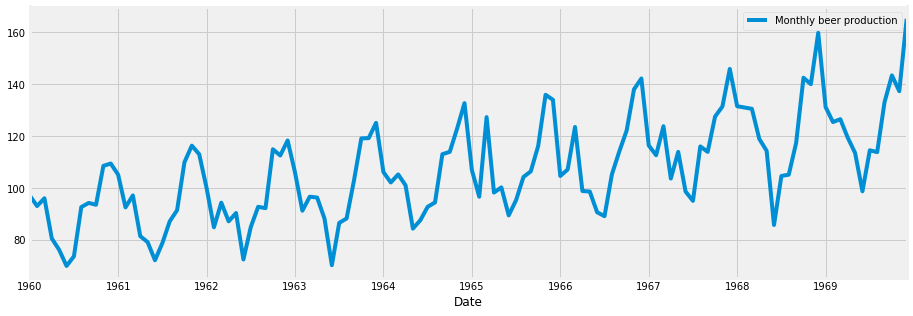

In [3]:
df.plot(figsize=(14,5))
plt.show

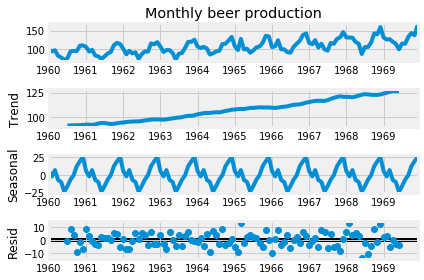

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Monthly beer production'], freq=12)
decomposition.plot()
plt.show()

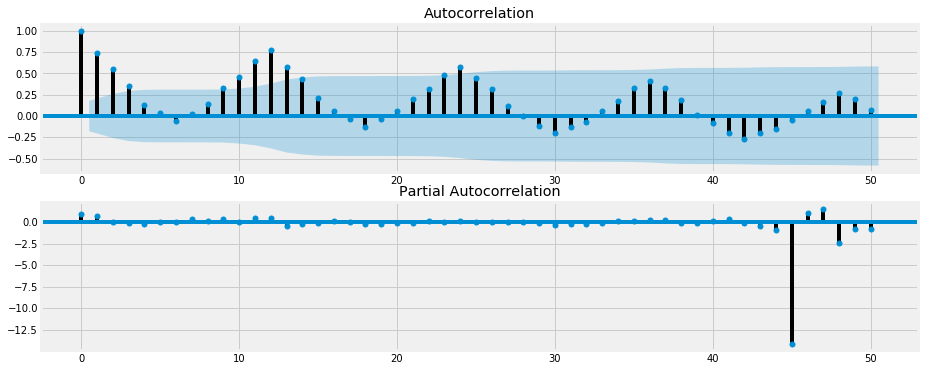

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

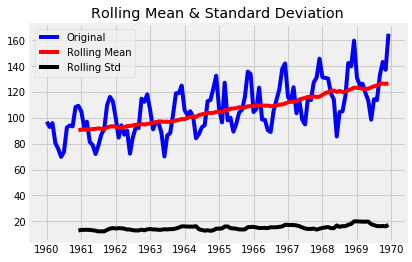

In [6]:

#Determing rolling statistics
rolmean = pd.Series(df['Monthly beer production']).rolling(window=12).mean()
rolstd = pd.Series(df['Monthly beer production']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Monthly beer production'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Monthly beer production'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   0.730400
p-value                          0.990425
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [8]:
df_diff = df.diff().diff(12)
df_diff.dropna(inplace=True)
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['Monthly beer production'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -4.191114
p-value                         0.000682
#Lags Used                     10.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


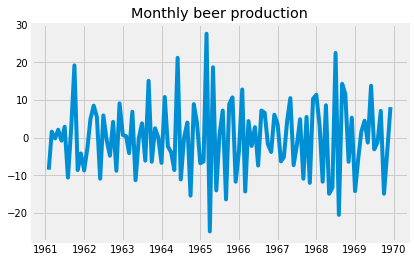

In [9]:
plt.plot(df_diff['Monthly beer production'])
plt.title('Monthly beer production')
plt.savefig('diffplot')
plt.show()

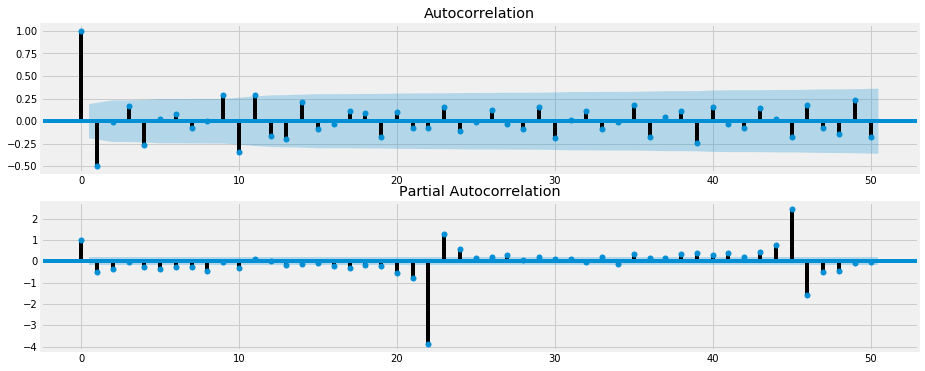

In [10]:

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

In [11]:
#pip install pmdarima
import pmdarima as pm
model = pm.auto_arima(df['Monthly beer production'], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=790.941, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=760.308, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=763.044, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=759.997, Time=0.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=789.497, Time=0.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=739.830, Time=0.95 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=740.758, Time=0.36 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=741.826, Time=1.20 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=741.809, Time=

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -363.915
Date:                            Fri, 14 Aug 2020   AIC                            739.830
Time:                                    14:14:48   BIC                            755.867
Sample:                                         0   HQIC                           746.331
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1338      0.763      0.175      0.861      -1.362       1.629
ar.L1         -0.7763      0.096     -8.089      0.000      -0.964      -0.588
ar.L2         -0.4742      0.082     -5.809      0.000      -0.634      -0.314
ar.S.L12      -0.4748      0.137     -3.458      0.001      -0.744      -0.206
ar.S.L24      -0.2018      0.119     -1.693      0.090      -0.436       0.032
sigma2        50.8167      7.412      6.856      0.000      36.289      65.344
===================================================================================
Ljung-Box (Q):                       84.04   Jarque-Bera (JB):                 1.29
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               1.59   Skew:                             0.25
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

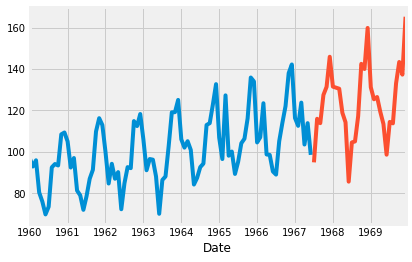

In [13]:
#divide into train and validation set
train = df[:int(0.75*(len(df)))]
test = df[int(0.75*(len(df))):]

#plotting the data
train['Monthly beer production'].plot()
test['Monthly beer production'].plot()

In [14]:
import statsmodels.api as sm
model = SARIMAX(train['Monthly beer production'],order=(1,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Monthly beer production   No. Observations:                   90
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -264.585
Date:                              Fri, 14 Aug 2020   AIC                            535.169
Time:                                      14:14:49   BIC                            542.200
Sample:                                  01-01-1960   HQIC                           537.982
                                       - 06-01-1967                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5294      0.125     -4.245      0.000      -0.774      -0.285
ma.S.L12      -0.3958      0.156     -2.535      0.011      -0.702      -0.090
sigma2        54.7949      7.672      7.142      0.000      39.758      69.831
===================================================================================
Ljung-Box (Q):                      120.79   Jarque-Bera (JB):                 8.06
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.89   Skew:                             0.71
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

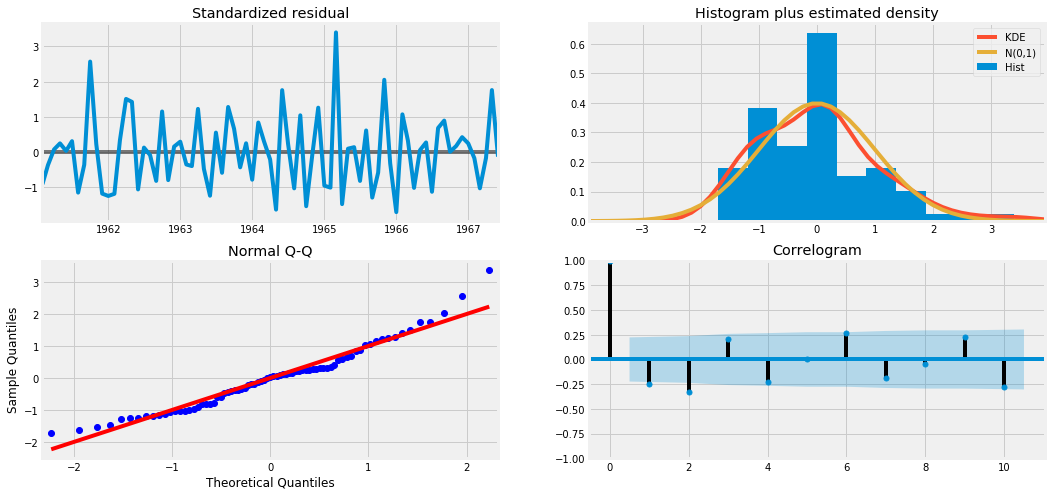

In [15]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

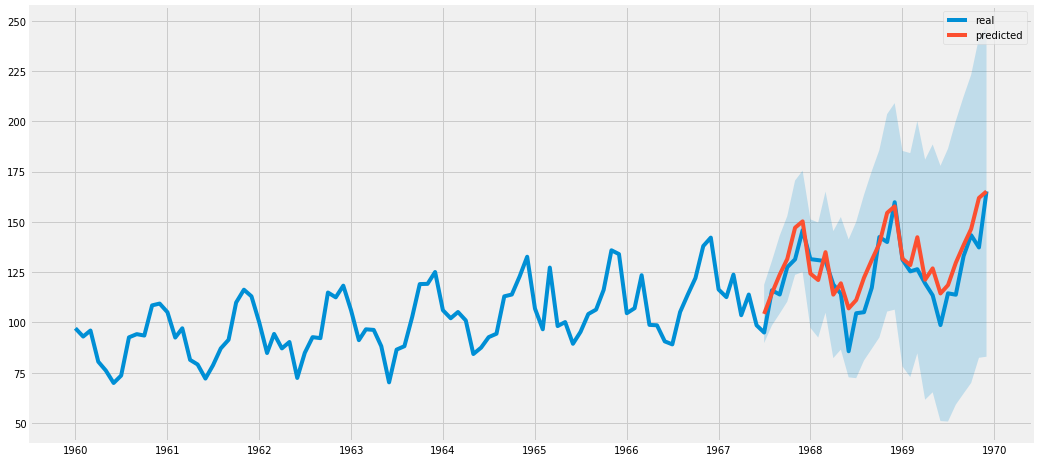

In [16]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df.index, df, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [17]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Monthly beer production'][i]}")

predicted=104.2501894, expected=95.0
predicted=114.5492311, expected=116.0
predicted=123.7906801, expected=113.9
predicted=131.6149842, expected=127.5
predicted=147.1382506, expected=131.4
predicted=150.2849736, expected=145.9
predicted=124.3086439, expected=131.5
predicted=121.0950484, expected=131.0
predicted=134.9814648, expected=130.5
predicted=113.8398372, expected=118.9
predicted=119.4722082, expected=114.3
predicted=107.0105939, expected=85.7
predicted=111.1580251, expected=104.6
predicted=122.2526889, expected=105.1
predicted=131.0729028, expected=117.3
predicted=139.1202261, expected=142.5
predicted=154.5254169, expected=140.0
predicted=157.734654 , expected=159.8
predicted=131.7252268, expected=131.2
predicted=128.5291545, expected=125.4
predicted=142.4062934, expected=126.5
predicted=121.2695776, expected=119.4
predicted=126.8993481, expected=113.5
predicted=114.4391107, expected=98.7
predicted=118.5858129, expected=114.5
predicted=129.6808626, expected=113.8
predicted=138.5

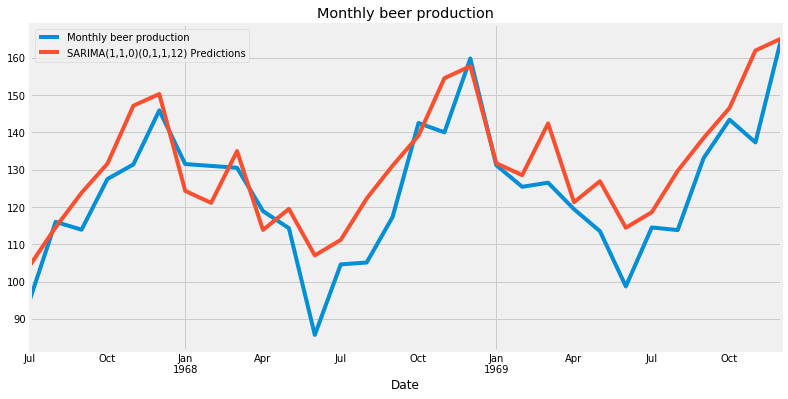

In [18]:

# Plot predictions against known values
title = 'Monthly beer production'
ax = test['Monthly beer production'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [19]:
r2_score(test['Monthly beer production'], predictions)

0.6227039597713996

In [20]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Monthly beer production'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Monthly beer production'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Monthly beer production'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Monthly beer production'])/np.abs(test['Monthly beer production']))*100 

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.622704,8.639334,116.96508,7.430225


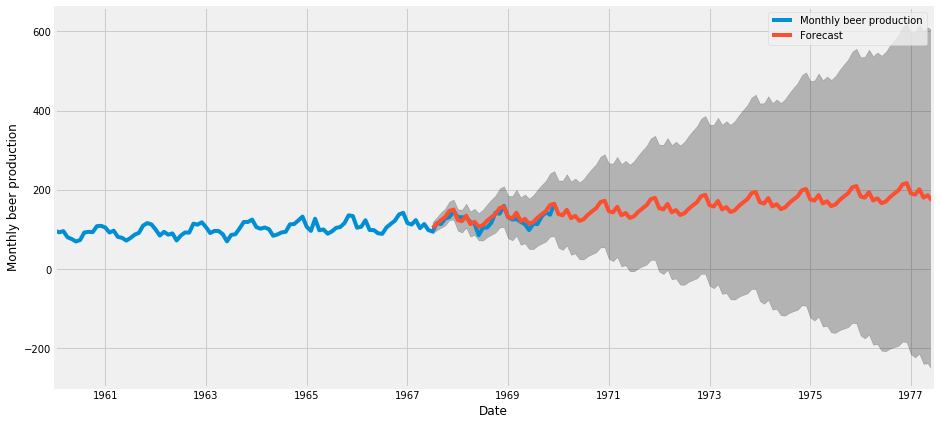

In [21]:
pred_f = results.get_forecast(steps=120)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Monthly beer production', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly beer production')
plt.legend()
plt.show()

In [22]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop('Month',1)
df = df[df.Date > '1959-12-01']
df = df[df.Date < '1980-01-01']
df.set_index('Date', inplace=True)